# MLP learning experiments on artificial generated signals

Multilayer perceptrons are a great way to classify data into multiple classes. They are simple, fast and still they are able to find non linear decision boundaries in your data. Admittedly, in contrast to deep learning the input to the network should be preprocessed and the features should be condensed to limit the number of inputs

Let's get our hands dirty. We are going to create some simple one dimensional data to showcase how to work with MLPs.

First, we need to prepare the notebook.

In [1]:
%matplotlib inline

import logging

logging.basicConfig(level=40)
logger = logging.getLogger()

To exercise our MLP skills, we will start with a very simple Dataset. It consists of wave forms over time. They can be thought of captured accelerometer data from repetitive gym exercises.

In [92]:
import numpy as np
import math
import random
from neon.datasets.dataset import Dataset

class GeneratedDS(Dataset):    
    # for each example we will generate 400 time steps
    feature_count = 400

    # number of examples to generate
    num_train_examples = 1000
    num_test_examples = 500
    
    # We will also give names to our classes to make reading easier
    human_labels = ['Active-Sitting', 'Advanced-Wobble-Board-Stand', 'Arm-Circles', 'Back-Extension', 'Bicep-Curl', 'Bosu-Balance', 'Bosu-Glute-Press', 'Bosu-Sit', 'Calf-Press', 'Captains-Chair', 'Chest-Fly', 'Chest-Press', 'Crunches', 'Decline-Chest-Press', 'Deltoid-Fly', 'Eversion', 'External-Rotation', 'Forearm-Curl', 'Front-Deltoid-Raise', 'Glute-Press', 'Glute-Squeeze', 'Hip-Abduction', 'Hip-Adduction', 'Incline-Chest-Press', 'Internal-Rotation', 'Inversion', 'Knee-Lift', 'Lat-Pull-down', 'Lateral-Deltoid-Raise', 'Lateral-Lunges-With-Medicine-Ball', 'Leg-Curl', 'Leg-Extension', 'Lunges', 'Oblique-Crunches', 'Oblique-Engagement', 'Oblique-Twist-With-Medicine-Ball', 'One-Leg-Stand', 'Plank', 'Pull-ups', 'Push-ups']
    num_classes = len(human_labels)
    
    # To the underlying sine waves we will add random noise with a maximum of noise_strength
    noise_strength = 5.0 / num_classes

    def human_label_for(self, id):
        return self.human_labels[id]
    
    # Get the characteristic (but madup) sinus curve of an excercise. Each exercise will 
    # feature a different period
    def period(self, exercise_class):
        return (exercise_class * 2.0 + 1) / self.num_classes * 10
    
    def amplitude(self, exercise_class):
        return exercise_class * 0.5 / self.num_classes + 0.5

    # Add some 'measurement' noise to the data to make the challenge slightly harder
    def sin_with_noise(self, x, period):
        noise = (random.random() - 0.5) * self.noise_strength
        return math.sin(x * 1.0 / period) + noise

    # Generate a single example for the given exercise class
    def generate_example(self, exercise_class):
        e = np.empty(self.feature_count)
        phase = random.random() * (self.period(exercise_class) * math.pi * 2)
        period = self.period(exercise_class)
        amplitude = self.amplitude(exercise_class)
        for t in range(0, self.feature_count):
            e[t] = self.sin_with_noise(random.random() + t + phase, period) * amplitude
        return e

    # Choose a random gym exercise
    def generate_label(self):
        return random.randint(0, self.num_classes - 1)

    # Generate `example_count` number of exercise examples
    def generate_input(self, example_count):
        d = np.empty((example_count, self.feature_count), dtype=float)
        l = np.zeros((example_count, self.num_classes), dtype=float)
        for i in range(0, example_count):
            label = self.generate_label()
            l[i, label] = 1
            d[i, :] = self.generate_example(label)
        return d, l

    # Now we need to do some plumbing to get the data into neon.
    def load(self, **kwargs):
        # Generate training and test datasets
        (data, labels) = self.generate_input(self.num_train_examples)
        self.inputs['train'] = data
        self.targets['train'] = labels

        (data, labels) = self.generate_input(self.num_test_examples)
        self.inputs['test'] = data
        self.targets['test'] = labels

        if 'format_data' not in kwargs or kwargs['format_data']:
            self.format()
            
    # Load label mapping and train / test data from disk.
    def __init__(self):
        (train_data, train_labels) = self.generate_input(self.num_train_examples)
        self.X_train = train_data
        self.y_train = train_labels

        (test_data, test_labels) = self.generate_input(self.num_test_examples)
        self.X_test = test_data
        self.y_test = test_labels
            
    # Now we need to do some plumbing to get the data into neon.
    def load(self, **kwargs):
        # Assign training and test datasets
        self.inputs['train'] = self.X_train
        self.targets['train'] = self.y_train

        self.inputs['test'] =  self.X_test
        self.targets['test'] = self.y_test

        self.format()
        
dataset = GeneratedDS()

print "Generated", dataset.num_train_examples, "training examples"

Generated 1000 training examples


Don't worry to much about the data generation. It is totally made up and in a real world problem that would be the part nature would handle for you. In that case you should think of the dataset more like a black box with no certain knowledge about how the data was generated.

Let's have a look at the generated data. We will plot some of the examples of the different classes.

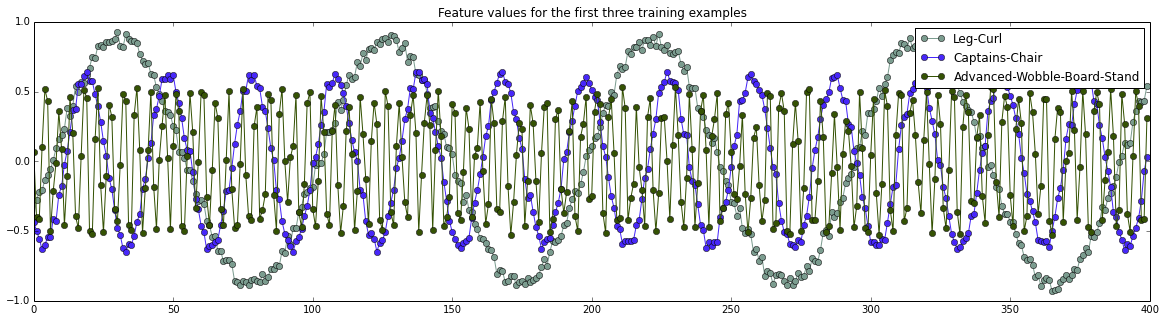

In [93]:
from matplotlib import pyplot, cm

plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, 3)

def label_of_example(i):
    class_id = np.where(dataset.y_train[i] == 1)[0][0]
    return dataset.human_label_for(class_id)

pyplot.figure(figsize=(20,5))
for i in plot_ids:
    c = np.random.random((3,))
    pyplot.plot(range(0, dataset.feature_count), dataset.X_train[i,], '-o', c=c)
    
pyplot.legend(map(label_of_example, plot_ids))
pyplot.title('Feature values for the first three training examples')
pyplot.show()

Visualizing the data as early in the process as possible is very important. It alows to get a first glimps and to instantly see if there is something wrong with the preprocessing.

Since the visualization of single examples doesn't show us much about the distribution of the classes, let's have a closer look at that as well.

In [94]:
from ipy_table import *
from operator import itemgetter

train_dist = np.reshape(np.transpose(np.sum(dataset.y_train, axis=0)), (dataset.num_classes,1))
test_dist = np.reshape(np.transpose(np.sum(dataset.y_test, axis=0)), (dataset.num_classes,1))

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_classes,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio))
table = np.vstack((np.zeros((1, 5), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_classes))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(0, align="left")

,Train,Train %,Test,Test %
Bosu-Balance,17,0.02%,14,0.03%
Deltoid-Fly,17,0.02%,12,0.02%
Plank,18,0.02%,11,0.02%
Back-Extension,19,0.02%,12,0.02%
Glute-Squeeze,19,0.02%,18,0.04%
One-Leg-Stand,20,0.02%,12,0.02%
Glute-Press,21,0.02%,15,0.03%
Advanced-Wobble-Board-Stand,22,0.02%,14,0.03%
Oblique-Engagement,22,0.02%,14,0.03%
Forearm-Curl,23,0.02%,14,0.03%


Now we are going dive into the actual model creation. We will start with a multilayer preceptron having 2 hidden layers.

In [124]:
from os.path import expanduser, exists
import os
from neon.backends import gen_backend
from neon.layers import FCLayer, DataLayer, CostLayer
from neon.models import MLP
from neon.transforms import RectLin, Logistic, CrossEntropy
from neon.experiments import FitPredictErrorExperiment
import cPickle as pkl
import shutil

# Directory where model snapshots are stored
working_directory = expanduser('~/data/signal-mlp')

# Make sure there is no old model lying around
if exists(working_directory):
    shutil.rmtree(working_directory)
os.makedirs(working_directory)
    
train_err = []
test_err = []

# We will see each training example exactly `max_epochs` times during training
max_epochs = 20

# Batch size is the number of examples that are grouped together and will together result in
# a single update of the network. One batch should be able to contain one example of each class.
batch_size = 32

print 'Epochs: %d Batch-Size: %d' % (max_epochs, batch_size)

# Setup of the network trainin parameters. Be carefull when choosing the learning rate
lrule = {'lr_params': {
            'learning_rate': 0.001,
            'momentum_params': {
                'coef': 0.9, 
                'type': 'constant'}},
         'type': 'gradient_descent_momentum'}

for num_epochs in range(0,max_epochs+1):
    # Set up the layers of our MLP
    layers = []
    layers.append(DataLayer(nout=dataset.feature_count))
    layers.append(FCLayer(nout=50, activation=RectLin(), lrule_init=lrule))
    layers.append(FCLayer(nout=50, activation=RectLin()))
    layers.append(FCLayer(nout=GeneratedDS.num_classes, activation=Logistic()))
    layers.append(CostLayer(cost=CrossEntropy()))

    # Set up model and experiment
    model = MLP(num_epochs=num_epochs, batch_size=batch_size, layers=layers,
                serialized_path=working_directory+'/signal-mlp.prm')
    
    # We will choose a fixed seed to create reproducable results
    backend = gen_backend(rng_seed=123)
    experiment = FitPredictErrorExperiment(model=model,
                                           backend=backend,
                                           dataset=dataset)

    # Run the training, and dump weights
    dest_path = working_directory+'/signal-ep' + str(num_epochs) + '.prm'
    print 'Trained for '+ str(num_epochs) +' epochs'
    if num_epochs > 0:
        res = experiment.run()
        train_err.append(res['train']['MisclassPercentage_TOP_1'])
        test_err.append(res['test']['MisclassPercentage_TOP_1'])
        # Save the weights at this epoch
        shutil.copy2(working_directory+'/signal-mlp.prm', dest_path)

    else:
        params = layers[1].weights.asnumpyarray()
        pkl.dump(params, open(dest_path,'w'))

print 'Finished training the MLP.'


Epochs: 20 Batch-Size: 32
Trained for 0 epochs
Trained for 1 epochs
Trained for 2 epochs
Trained for 3 epochs


Trained for 4 epochs
Trained for 5 epochs


Trained for 6 epochs
Trained for 7 epochs


Trained for 8 epochs
Trained for 9 epochs


Trained for 10 epochs
Trained for 11 epochs


Trained for 12 epochs
Trained for 13 epochs


Trained for 14 epochs
Trained for 15 epochs


Trained for 16 epochs
Trained for 17 epochs


Trained for 18 epochs
Trained for 19 epochs


Trained for 20 epochs
Finished training the MLP.


To check weather the network is learning something we will plot the weight matrices of the different training epochs. They should show some structure. If the are completly white or black the training collapsed and you probably need to choose a different learning rate or model.

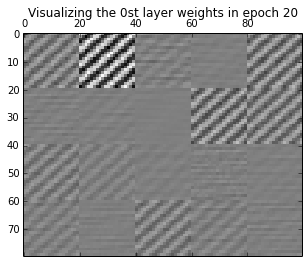

In [125]:
import numpy as np
from matplotlib import pyplot, cm
from IPython.html import widgets
from IPython.html.widgets import interact

nrows = 4
ncols = 5
fr = math.sqrt(dataset.feature_count)

def plot_filters(**kwargs):
    n = kwargs['n']
    dest_path = expanduser('~/data/signal-dl/signal-ep' + str(n) + '.prm')
    params = pkl.load(open(dest_path, 'r'))
    if n>0:
        wts = params['layer_1']['weights']
    else:
        wts = params

    fi = 0

    W = np.zeros((fr*nrows, fr*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fr*col:fr*(col+1)] = wts[fi].reshape(20,20)
        fi = fi + 1

    pyplot.matshow(W, cmap=cm.gray)
    pyplot.title('Visualizing the 0st layer weights in epoch ' + str(n) )
    pyplot.show()

_i = interact(plot_filters,
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs, value=0))

Another good thing to visualize is the development of the test and train loss over the epochs. Train and test loss should be similar. If they differ to much the model suffers from over- or underfitting.

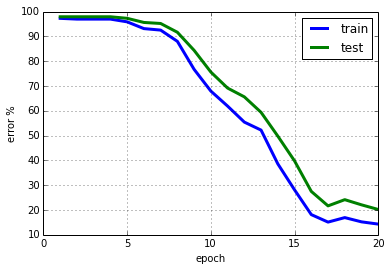

In [126]:
pyplot.plot(range(1, max_epochs+1), train_err, linewidth=3, label='train')
pyplot.plot(range(1, max_epochs+1), test_err, linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("error %")
pyplot.show()

As a final evaluation step we will create a confusion matrix to see, if there are certain classes that get mistaken very often. If that is the case, one should try to get more training examples for those classes.

In [127]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

# confusion_matrix(y_true, y_pred)
predicted, actual = model.predict_fullset(dataset, "test")

y_pred = np.argmax(predicted.asnumpyarray(), axis = 0) 
y_true = np.argmax(actual.asnumpyarray(), axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_classes))

# Fiddle around with cm to get it into table shape
confusion_mat = np.vstack((np.zeros((1,dataset.num_classes), dtype=int), confusion_mat))
confusion_mat = np.hstack((np.zeros((dataset.num_classes + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_classes))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_classes + 1):
    for j in range(1, dataset.num_classes + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,Active-Sitting,Advanced-Wobble-Board-Stand,Arm-Circles,Back-Extension,Bicep-Curl,Bosu-Balance,Bosu-Glute-Press,Bosu-Sit,Calf-Press,Captains-Chair,Chest-Fly,Chest-Press,Crunches,Decline-Chest-Press,Deltoid-Fly,Eversion,External-Rotation,Forearm-Curl,Front-Deltoid-Raise,Glute-Press,Glute-Squeeze,Hip-Abduction,Hip-Adduction,Incline-Chest-Press,Internal-Rotation,Inversion,Knee-Lift,Lat-Pull-down,Lateral-Deltoid-Raise,Lateral-Lunges-With-Medicine-Ball,Leg-Curl,Leg-Extension,Lunges,Oblique-Crunches,Oblique-Engagement,Oblique-Twist-With-Medicine-Ball,One-Leg-Stand,Plank,Pull-ups,Push-ups
Active-Sitting,8,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Advanced-Wobble-Board-Stand,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arm-Circles,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Back-Extension,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bicep-Curl,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bosu-Balance,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bosu-Glute-Press,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bosu-Sit,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Calf-Press,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Captains-Chair,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
